<a href="https://colab.research.google.com/github/hemil19/AISem3/blob/master/hw/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Submission by : Hemil Shah(D011)**

In [ ]:
#!pip3 install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [ ]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [ ]:
!kaggle competitions download -c home-credit-default-risk

 91% 99.0M/109M [00:00<00:00, 126MB/s]
100% 109M/109M [00:00<00:00, 124MB/s] 
 86% 5.00M/5.81M [00:00<00:00, 35.3MB/s]
100% 5.81M/5.81M [00:00<00:00, 37.0MB/s]
 90% 33.0M/36.8M [00:00<00:00, 73.9MB/s]
100% 36.8M/36.8M [00:00<00:00, 74.8MB/s]
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
 95% 92.0M/96.7M [00:00<00:00, 117MB/s]
100% 96.7M/96.7M [00:00<00:00, 117MB/s]
 96% 260M/271M [00:02<00:00, 125MB/s]
100% 271M/271M [00:02<00:00, 114MB/s]
 89% 68.0M/76.3M [00:00<00:00, 95.0MB/s]
100% 76.3M/76.3M [00:00<00:00, 90.9MB/s]
 88% 50.0M/56.8M [00:01<00:00, 32.4MB/s]
100% 56.8M/56.8M [00:01<00:00, 45.0MB/s]
 83% 30.0M/36.1M [00:00<00:00, 69.0MB/s]
100% 36.1M/36.1M [00:00<00:00, 72.6MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  POS_CASH_balance.csv.zip
replace POS_CASH_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  application_test.csv.zip
replace application_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  bureau.csv.zip
replace bureau.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  credit_card_balance.csv.zip
replace credit_card_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  installments_payments.csv.zip
replace installments_payments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  previous_application.csv.zip
replace previous_application.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  bureau_balance.csv.zip
replace bureau_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  application_train.csv.zip
replace application_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

8 archives were successfully processed.


In [ ]:
!ls

application_test.csv	 HomeCredit_columns_description.csv
application_train.csv	 installments_payments.csv
bureau_balance.csv	 kaggle.json
bureau.csv		 POS_CASH_balance.csv
catboost_info		 previous_application.csv
credit_card_balance.csv  sample_submission.csv


In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
train=pd.read_csv('application_train.csv')
#bureau=pd.read_csv('bureau.csv')
#bureau_balance=pd.read_csv('bureau_balance.csv')
#credit_card_balance=pd.read_csv('credit_card_balance.csv')
#installments_payments=pd.read_csv('installments_payments.csv')
#previous_application=pd.read_csv('previous_application.csv')
#POS_CASH_balance=pd.read_csv('POS_CASH_balance.csv')

In [ ]:
train.shape

(307511, 122)

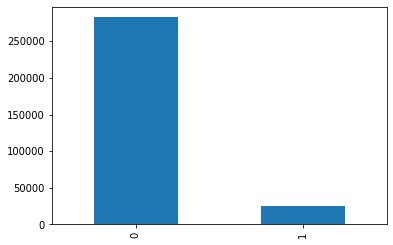

In [ ]:
train['TARGET'].value_counts().plot(kind='bar')

As there are too many rows and also the target variable is imbalanced so for faster computation i choose to take random sample of the train dataset

In [ ]:
train=train.sample(frac =.30) 

In [ ]:
train['TARGET'].value_counts()

0    84846
1     7407
Name: TARGET, dtype: int64

In [ ]:
numeric_columns=train.select_dtypes(include=['number']).columns

In [ ]:
categorical_columns=set(train.columns)-set(numeric_columns)

In [ ]:
len(numeric_columns)+len(categorical_columns)==len(train.columns)

True

In [ ]:
#filling numerical values with mean
for i in numeric_columns:
  train[i].fillna(train[i].mean(),inplace=True)

In [ ]:
#filling categorical values with mode
for i in categorical_columns:
  train[i].fillna(train[i].mode()[0],inplace=True)

In [ ]:
#checking if there are any null values
train.columns[train.isnull().sum()>0]

Index([], dtype='object')

In [ ]:
X=train.drop(['TARGET','SK_ID_CURR'],axis=1)
y=train['TARGET']

In [ ]:
X.shape

(92253, 120)

In [ ]:
X['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [ ]:
dict_map={'Higher education':4, 'Secondary / secondary special':1,
       'Incomplete higher':3, 'Lower secondary':0, 'Academic degree':2}
X['NAME_EDUCATION_TYPE']=X['NAME_EDUCATION_TYPE'].map(dict_map)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in categorical_columns:
  if i!='NAME_EDUCATION_TYPE':
    X[i]=le.fit_transform(X[i])

In [ ]:
X['AMT_CREDIT']=np.log1p(X['AMT_CREDIT'])
X['AMT_INCOME_TOTAL']=np.log1p(X['AMT_INCOME_TOTAL'])
X['AMT_ANNUITY']=np.log1p(X['AMT_ANNUITY'])
X['AMT_GOODS_PRICE']=np.log1p(X['AMT_GOODS_PRICE'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [ ]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
227715,0,0,0,1,1,12.323860,13.046564,10.212093,13.046564,6,4,1,2,1,0.018209,-15552,-2116,-4890.0,-5487,12.106462,1,1,0,1,1,0,11,2.0,3,3,1,7,0,0,0,0,0,0,30,0.501134,...,0.101865,0.108596,0.008742,0.02848,2,0,0.102585,4,0,3.0,0.0,3.0,0.0,-1490.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
302014,0,1,0,1,0,12.660331,13.715139,10.285667,13.715139,1,1,1,1,1,0.028663,-13294,-1770,-7388.0,-4159,12.106462,1,1,0,1,0,0,8,2.0,2,2,4,14,0,1,1,0,1,1,7,0.221321,...,0.185600,0.177300,0.003900,0.02520,2,0,0.176500,4,0,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
281483,1,0,0,0,0,11.119898,12.100718,9.105091,12.100718,1,7,3,3,5,0.010276,-7832,-1121,-7806.0,-524,12.106462,1,1,1,1,1,0,8,1.0,2,2,5,11,0,1,1,0,1,1,34,0.501134,...,0.101865,0.108596,0.008742,0.02848,2,0,0.102585,4,0,12.0,0.0,11.0,0.0,-1039.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
298169,0,0,0,0,1,12.218500,13.569509,10.687172,13.422469,1,7,4,1,1,0.020246,-15271,-394,-4106.0,-4106,12.106462,1,1,0,1,0,0,3,3.0,3,3,2,9,0,0,0,0,1,1,39,0.792077,...,0.101865,0.108596,0.008742,0.02848,2,0,0.102585,4,0,10.0,0.0,10.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
107258,0,0,0,1,0,12.173038,13.661958,10.504218,13.448787,6,7,1,1,1,0.020713,-19966,-1207,-12086.0,-3490,12.106462,1,1,0,1,0,0,8,2.0,3,2,3,12,0,0,0,0,0,0,39,0.501134,...,0.101865,0.108596,0.008742,0.02848,2,0,0.102585,4,0,0.0,0.0,0.0,0.0,-1972.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0


Logistic Regression Base Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
clf=LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9226
           1       0.00      0.00      0.00         0

    accuracy                           0.93      9226
   macro avg       0.50      0.46      0.48      9226
weighted avg       1.00      0.93      0.96      9226



Logistic Regression with parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [    
    {'penalty' : ['l1', 'l2'],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'max_iter' : [100,2500]
    }
]
gridclf = GridSearchCV(clf, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)
best_clf = gridclf.fit(X_train,y_train)
print(classification_report(best_clf.predict(X_test),y_test))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.5min finished


              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9210
           1       0.02      0.69      0.03        16

    accuracy                           0.93      9226
   macro avg       0.51      0.81      0.50      9226
weighted avg       1.00      0.93      0.96      9226



Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf=RandomForestClassifier().fit(X_train,y_train)
y_pred=rfclf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9225
           1       0.00      1.00      0.00         1

    accuracy                           0.93      9226
   macro avg       0.50      0.96      0.48      9226
weighted avg       1.00      0.93      0.96      9226



XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
xgbclf = XGBClassifier(objective='binary:logistic')
xgbclf.fit(X_train,y_train)
y_pred=xgbclf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9216
           1       0.01      0.60      0.02        10

    accuracy                           0.93      9226
   macro avg       0.50      0.76      0.49      9226
weighted avg       1.00      0.93      0.96      9226



LightGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier
m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994,
                   eval_metric='Logloss')
m.fit(X_train, y_train,verbose=2)
y_pred=m.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9167
           1       0.04      0.42      0.07        59

    accuracy                           0.92      9226
   macro avg       0.52      0.68      0.51      9226
weighted avg       0.99      0.92      0.95      9226

